<a href="https://colab.research.google.com/github/JonHaz/Capstone-2-LVMH-Sales-in-Iowa/blob/main/LVMH_Capstone_Two_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I will be testing out different machine learning models to predict sales

*   ARIMA
*   Linear Regression
*   Random Forest Regression
*   XGBoost
*   Long Short Term Memory

My game plan is to


*   split the data into train and test
*   create a pipeline
*   perform 5 fold cross validation
*   use gradient boosting to determine what learning rate has the best accuracy
*   Random Search to determine what is a good enough parameter

Limit the number of unique values in my dataset by grouping them

Replace a category with the average 

In [1]:
#Packages I will be using
import pandas as pd
from datetime import datetime, timedelta
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
#https://github.com/srpraveen97/Electrical_Demand_Toronto/blob/main/Jupyter%20Notebooks/LinearModel_TimeSeries.ipynb

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# I am establishing a connection to my Sandbox within BigQuery so that I can run SQL queries to interact with the data here within Google Collab
from google.colab import auth
auth.authenticate_user()
print('Authenticated')


Authenticated


In [4]:
# Save output in a variable `df`
%%bigquery --project storied-sound-253213 df
SELECT *
FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE vendor_number = '420'

In [5]:
df.nunique()

invoice_and_item_number    260666
date                         2011
store_number                 2185
store_name                   2314
address                      3183
city                          722
zip_code                      452
store_location               1772
county_number                 108
county                        199
category                       17
category_name                  19
vendor_number                   1
vendor_name                     2
item_number                   181
item_description              166
pack                           11
bottle_volume_ml               17
state_bottle_cost             174
state_bottle_retail           179
bottles_sold                   97
sale_dollars                 1859
volume_sold_liters            210
volume_sold_gallons           253
dtype: int64

In [6]:
#applying a little data cleaning
#changing data types for 'date', 'pack', 'bottle_volume_ml'
df['date'] = pd.to_datetime(df['date'])
add_cat = ['pack', 'bottle_volume_ml']
df[add_cat] = df[add_cat].astype(str)
#removing fields that are unique identifiers, are redundant, or have more than 100 unique options
# ['invoice_and_item_number' , 'vendor_number','vendor_name', 'store_name', 'address','item_description', 'item_number', 'store_number', 'city', 'zip_code', 'store_location', 'county_number', 'county']
remove_cat = ['invoice_and_item_number' , 'vendor_number','vendor_name', 'store_name', 'address','item_description', 'item_number', 'store_number', 'city', 'zip_code', 'store_location', 'county_number', 'county']
df_cat = df.drop(columns=remove_cat)

In [7]:
# select object type columns
dfo=df_cat.select_dtypes(include=['object']) 
df = pd.concat([df.drop(dfo, axis=1), pd.get_dummies(dfo)], axis=1)

In [8]:
# lets move the field 'invoice_and_item_number' to the index
df = df.set_index('invoice_and_item_number')

# creating a series of dates
df_date = df['date']

# dropping columns so that the data can be scaled
cat = ['date','store_number',	'store_name',	'address',	'city',	'zip_code',	'store_location',	'county_number',	'county',	'vendor_number',	'vendor_name',	'item_number',	'item_description']
df_scaled = df.drop(columns=cat)

In [9]:
print(df.nunique())
print(df['county_number'].unique())

date                    2011
store_number            2185
store_name              2314
address                 3183
city                     722
                        ... 
bottle_volume_ml_603       2
bottle_volume_ml_750       2
bottle_volume_ml_800       2
bottle_volume_ml_850       2
bottle_volume_ml_900       2
Length: 83, dtype: int64
['77' '82' '51' '85' '62' '4' '57' '07' '25' '52' '7' '06' '96' '31' '86'
 '91' '71' '64' '29' '97' '08' '17' '11' '78' '24' '14' '50' '34' '30'
 '63' '92' None '88' '94' '23' '70' '79' '90' '54' '53' '59' '8' '44' '48'
 '21' '43' '9' '58' '56' '84' '40' '33' '95' '75' '73' '09' '42' '99' '04'
 '69' '55' '6' '46' '32' '66' '60' '83' '37' '16' '03' '61' '15' '47' '67'
 '28' '3' '49' '27' '65' '10' '74' '18' '81' '68' '02' '5' '93' '45' '22'
 '35' '20' '76' '19' '98' '72' '13' '12' '38' '01' '05' '41' '80' '39'
 '36' '87' '89' '1' '2' '26']


In [10]:
# I created a lookup table in Google Sheets that grouped county number by district per the Iowa Department of Transportation
# I am importing that googlesheet and creating a dataframe

!pip install --upgrade -q gspread

import gspread
import pandas as pd
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('Districts Iowa Department of Transportation').sheet1
rows = worksheet.get_all_values()
district = pd.DataFrame.from_records(rows)

In [11]:
#formatting the new data frame
column = ['count_number', 'district']
district.set_axis(column, axis=1, inplace=True)
district = district.drop(0)
district.head()

,count_number,district
1,1,3
2,2,3
3,3,3
4,4,3
5,5,2


In [12]:
#merged the district df with my existing df
new_df =df.merge(district,left_on='county_number', right_on='count_number')

new_df.columns

Index(['date', 'store_number', 'store_name', 'address', 'city', 'zip_code',
       'store_location', 'county_number', 'county', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'state_bottle_cost',
       'state_bottle_retail', 'bottles_sold', 'sale_dollars',
       'volume_sold_liters', 'volume_sold_gallons', 'category_1012200',
       'category_1012210', 'category_1012300', 'category_1022200',
       'category_1032000', 'category_1032080', 'category_1032100',
       'category_1032200', 'category_1052010', 'category_1052100',
       'category_1062050', 'category_1062200', 'category_1082100',
       'category_1082900', 'category_1700000', 'category_1701100',
       'category_1901200', 'category_name_BARBADOS RUM',
       'category_name_DECANTERS & SPECIALTY PACKAGES',
       'category_name_IMPORTED GRAPE BRANDIES', 'category_name_IMPORTED VODKA',
       'category_name_IMPORTED VODKA - MISC', 'category_name_IRISH WHISKIES',
       'category_name_Imported Brandie

In [13]:
#adding new columns
new_df['year'] = pd.DatetimeIndex(new_df['date']).year
new_df['month'] = pd.DatetimeIndex(new_df['date']).month
new_df['week'] = pd.DatetimeIndex(new_df['date']).week

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  after removing the cwd from sys.path.


In [14]:
new_df.columns

Index(['date', 'store_number', 'store_name', 'address', 'city', 'zip_code',
       'store_location', 'county_number', 'county', 'vendor_number',
       'vendor_name', 'item_number', 'item_description', 'state_bottle_cost',
       'state_bottle_retail', 'bottles_sold', 'sale_dollars',
       'volume_sold_liters', 'volume_sold_gallons', 'category_1012200',
       'category_1012210', 'category_1012300', 'category_1022200',
       'category_1032000', 'category_1032080', 'category_1032100',
       'category_1032200', 'category_1052010', 'category_1052100',
       'category_1062050', 'category_1062200', 'category_1082100',
       'category_1082900', 'category_1700000', 'category_1701100',
       'category_1901200', 'category_name_BARBADOS RUM',
       'category_name_DECANTERS & SPECIALTY PACKAGES',
       'category_name_IMPORTED GRAPE BRANDIES', 'category_name_IMPORTED VODKA',
       'category_name_IMPORTED VODKA - MISC', 'category_name_IRISH WHISKIES',
       'category_name_Imported Brandie

In [15]:
sales_district_year = new_df.groupby(['district','year'])['sale_dollars'].agg('sum')
sales_district_month = new_df.groupby(['district','month'])['sale_dollars'].agg('sum')
sales_district_week = new_df.groupby(['district','week'])['sale_dollars'].agg('sum')
#sales_district.sort_values(ascending=True).head()
sales_district_year = sales_district_year.reset_index(level='district')
sales_district_month = sales_district_month.reset_index(level='district')
sales_district_week = sales_district_week.reset_index(level='district')

In [16]:
sales_district_week.head()

,district,sale_dollars
week,,
1,1,5201.05
2,1,6410.62
3,1,6130.21
4,1,6650.12
5,1,6674.88


Weekly sales throughout a calendar year

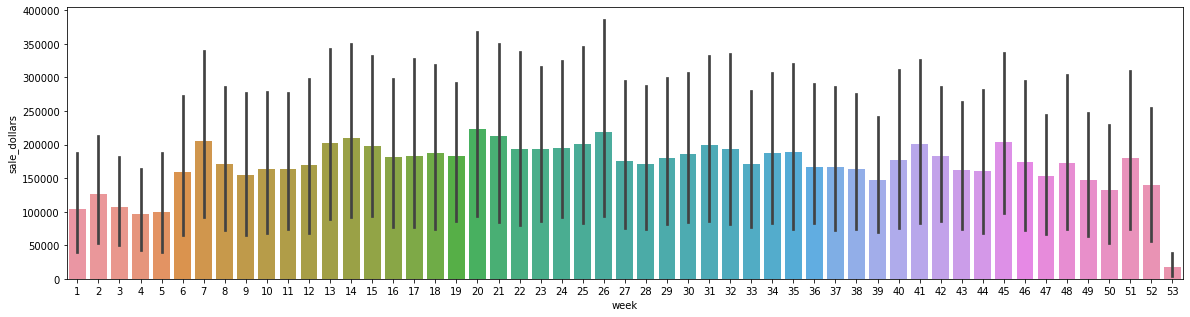

In [17]:
plt.figure(figsize=(20,5))
x = sales_district_week.index
y = sales_district_week['sale_dollars']
hue = sales_district_week['district']

sns.barplot(x=x, y=y)

In [18]:
sales_district_year.head()

,district,sale_dollars
year,,
2012,1,42745.55
2013,1,42995.90
2014,1,45753.00
2015,1,41908.83
2016,1,52867.27


[Text(0, 0.5, 'Millions'), Text(0.5, 0, 'Districts')]

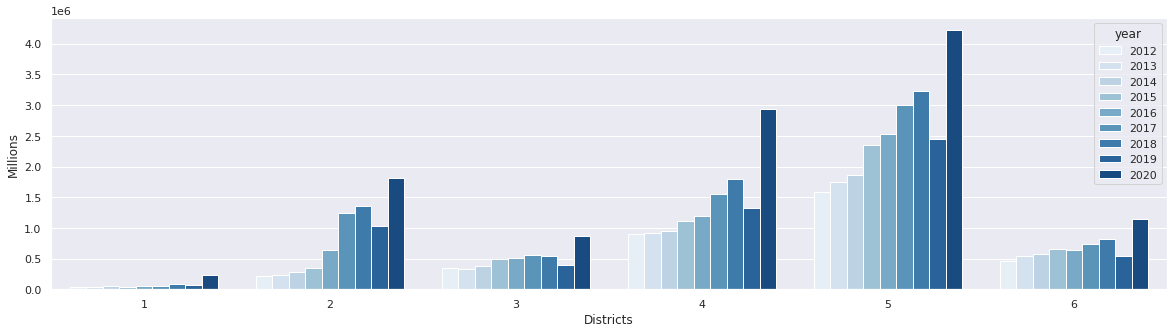

In [19]:

plt.figure(figsize=(20,5))

sns.set_theme(style="darkgrid")
x = sales_district_year['district']
y = sales_district_year['sale_dollars']
hue = sales_district_year.index
ax = sns.barplot(y=y, x=x, hue=hue, palette='Blues')

ax.set(xlabel='Districts', ylabel='Millions')

By plotting sales by ditrict over the years we can see that there is year over year sales growth.

[Text(0, 0.5, 'Millions'), Text(0.5, 0, 'Districts')]

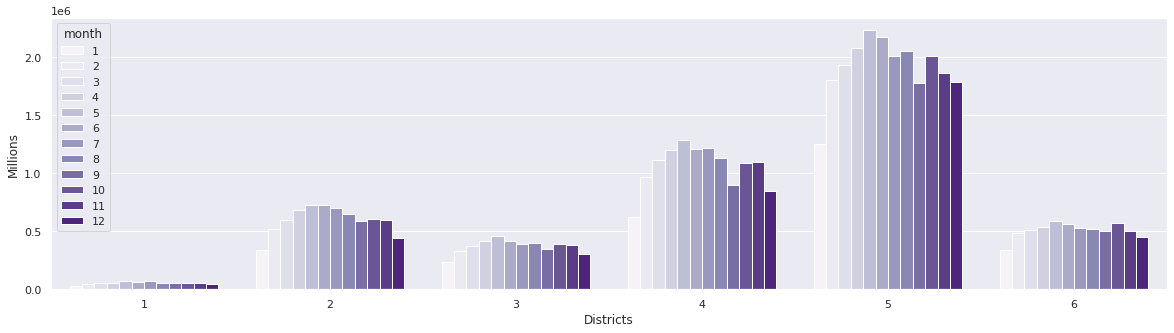

In [20]:
plt.figure(figsize=(20,5))

sns.set_theme(style="darkgrid")
x = sales_district_month['district']
y = sales_district_month['sale_dollars']
hue = sales_district_month.index
ax = sns.barplot(y=y, x=x, hue=hue, palette='Purples')

ax.set(xlabel='Districts', ylabel='Millions')

Showing sales by month by distict shows that for some regions there is a seasonal trend

In [21]:
#Using StandardScaler to normalize my data
scaler = StandardScaler()
scaler.fit(df_scaled)

#joining df_scaled to df_date on their indexes which is "invoice_and_item_number"
df = df_scaled.join(df_date, lsuffix='_df_scaled', rsuffix='_df_date')

#ordering the data by date
df = df.sort_values(by='date')


In [22]:
#establishing what my independent and dependent variable should be
X = df.loc[:,df.columns!="sale_dollars"]
y = df['sale_dollars']
test_size = 0.2
date_col = df.date

In [23]:
# using train_test_split making sure that my data is not shuffled since it is time series
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size, shuffle= False)

Now that we have our data training data we can begin applying different models

ARIMA Model

In [24]:
# I don not need all of these fields for an ARIMA Model so I going to create a new dataset
df.head()


,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,category_1012200,category_1012210,category_1012300,category_1022200,category_1032000,category_1032080,category_1032100,category_1032200,category_1052010,category_1052100,category_1062050,category_1062200,category_1082100,category_1082900,category_1700000,category_1701100,category_1901200,category_name_BARBADOS RUM,category_name_DECANTERS & SPECIALTY PACKAGES,category_name_IMPORTED GRAPE BRANDIES,category_name_IMPORTED VODKA,category_name_IMPORTED VODKA - MISC,category_name_IRISH WHISKIES,category_name_Imported Brandies,category_name_Imported Flavored Vodka,category_name_Imported Vodka,category_name_Imported Vodkas,category_name_MISC. IMPORTED CORDIALS & LIQUEURS,category_name_PUERTO RICO & VIRGIN ISLANDS RUM,category_name_SCOTCH WHISKIES,category_name_SINGLE MALT SCOTCH,category_name_Scotch Whiskies,category_name_Single Malt Scotch,category_name_Special Order Items,category_name_Temporary & Specialty Packages,category_name_Temporary & Specialty Packages,pack_1,pack_10,pack_12,pack_2,pack_24,pack_3,pack_4,pack_48,pack_6,pack_8,pack_96,bottle_volume_ml_100,bottle_volume_ml_1000,bottle_volume_ml_1200,bottle_volume_ml_1500,bottle_volume_ml_1750,bottle_volume_ml_200,bottle_volume_ml_2250,bottle_volume_ml_2550,bottle_volume_ml_375,bottle_volume_ml_400,bottle_volume_ml_50,bottle_volume_ml_600,bottle_volume_ml_603,bottle_volume_ml_750,bottle_volume_ml_800,bottle_volume_ml_850,bottle_volume_ml_900,date
invoice_and_item_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
S03381400032,23.31,34.96,36,1258.56,27.00,7.13,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2012-01-03
S03388500019,17.06,25.59,12,307.08,9.00,2.38,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2012-01-03
S03409700050,17.15,25.73,2,51.46,1.50,0.40,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2012-01-03
S03393900086,11.49,17.24,1,17.24,0.38,0.10,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2012-01-03
S03410400020,17.06,25.59,1,25.59,0.75,0.20,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2012-01-03


In [27]:
df_arima = df.reset_index()[['date','sale_dollars','volume_sold_liters']].groupby('date')[['sale_dollars','volume_sold_liters']].sum()

df_arima

,sale_dollars,volume_sold_liters
date,,
2012-01-03,15105.42,403.23
2012-01-04,8984.70,251.53
2012-01-05,18980.12,511.03
2012-01-09,12762.83,341.10
2012-01-10,8932.77,239.97
...,...,...
2020-11-24,64408.16,1486.42
2020-11-25,14321.38,324.33
2020-11-27,41238.41,959.99


In [29]:
#Testing if my data is trend stationary using the Dicky Fuller Statistical Test
from statsmodels.tsa.stattools import adfuller
results = adfuller(df_arima['sale_dollars'])
print(results)

(-3.0012966088207875, 0.034773490619154475, 24, 1986, {'1%': -3.4336469649065298, '5%': -2.862996415949189, '10%': -2.5675453345421984}, 42848.40868224585)


Dicky Fuller Test tells us a few things
1. There is a high likelyhood that the data is stationary because the test statistic (0th value) of the tuple is negative
2. The p value (1st value) of the tuple is less than 0.05 meaning we can safely reject the null hypothesis, reject the notion that the data is not stationary
3. The critical values contained within the dictionary within the tuple further support that the data is stationary given that I am using a test statisti of 5%

In [30]:
# using train_test_split making sure that my data is not shuffled since it is time series
from sklearn.model_selection import train_test_split
X = df_arima.index
y= df_arima

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=test_size, shuffle= False)

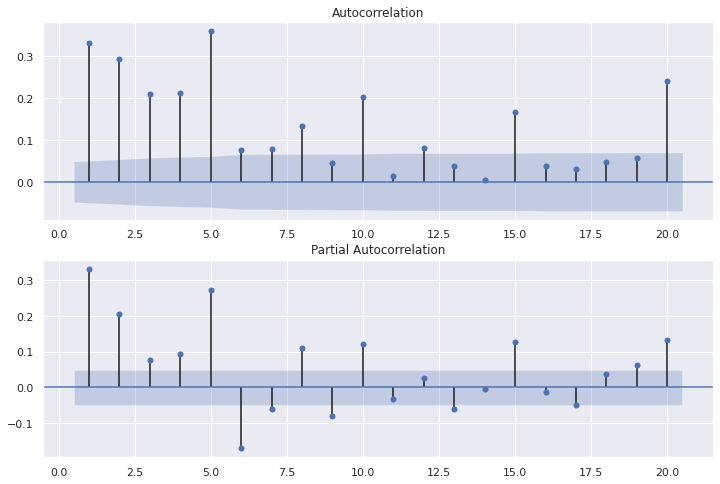

In [60]:
#determine the model order by plotting the acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot the ACF of df
plot_acf(y_train['sale_dollars'], lags=20, zero=False, ax=ax1)

# Plot the PACF of df
plot_pacf(y_train['sale_dollars'], lags=20, zero=False, ax=ax2)

plt.show()

In [69]:
# it is not clear what the order model should be so I will be using the aic and bic to determine this
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-3
for p in range(5):
  # Loop over q values from 0-3
    for q in range(5):
      	# create and fit ARMA(p,q) model
        model = SARIMAX(y_train['sale_dollars'], order=(p,0,q))
        results = model.fit()

        # Append order and results tuple
        order_aic_bic.append((p,q,results.aic, results.bic))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

In [80]:
#For order values that may cause errors
# Loop over p values from 0-2
for p in range(3):
    # Loop over q values from 0-2
    for q in range(3):
      
        try:
            # create and fit ARMA(p,q) model
            model = SARIMAX(y_train['sale_dollars'], order=(p,0,q))
            results = model.fit()
            
            # Print order and results
            print(p, q, results.aic, results.bic)
            
        except:
            print(p, q, None, None)     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0 0 37515.11482194797 37520.49756839771
0 1 36771.4380701135 36782.203563012976
0 2 36481.94690524609 36498.09514459531
1 0 35383.12777551754 35393.893268417014


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1 1 34808.0115829221 34824.15982227132


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


1 2 34776.10981656778 34797.64080236674
2 0 35052.68299638231 35068.83123573153


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2 1 34756.261591244416 34777.79257704337


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2 2 34797.8149957093 34824.72872795799


In [76]:
#Make dataframe of model order
order_df = pd.DataFrame(order_aic_bic, columns=['p','q','aic','bic'])

#sort by aic
print(order_df.sort_values('aic').head())

#sort by bic
print(order_df.sort_values('bic').head())

p = 4
q = 3

#p = order_aic_bic['p'].min('aic')
#q = order_aic_bic['q'].min('aic')
print('for our model the order value for p is :',p,'q is :',q)

    p  q           aic           bic
23  4  3  34606.735904  34649.797875
24  4  4  34610.500424  34658.945142
19  3  4  34631.989876  34675.051848
18  3  3  34687.135543  34724.814768
22  4  2  34713.708455  34751.387681
    p  q           aic           bic
23  4  3  34606.735904  34649.797875
24  4  4  34610.500424  34658.945142
19  3  4  34631.989876  34675.051848
18  3  3  34687.135543  34724.814768
22  4  2  34713.708455  34751.387681
for our model the order value for p is : 4 q is : 3


In [77]:
# Fit an ARMA model to the data
model = ARMA(y_train['sale_dollars'], order=(p,q), exog=y_train['volume_sold_liters'])
res = model.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for theta
print("When the true theta=-0.9, the estimate of theta (and the constant) are:")
print(res.params)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:           sale_dollars   No. Observations:                 1608
Model:                     ARMA(4, 3)   Log Likelihood              -13856.692
Method:                       css-mle   S.D. of innovations           1330.955
Date:                Fri, 06 Aug 2021   AIC                          27733.384
Time:                        13:33:07   BIC                          27787.212
Sample:                             0   HQIC                         27753.367
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -383.0937      1.101   -348.098      0.000    -385.251    -380.937
volume_sold_liters    40.5702      0.117    348.098      0.000      40.342      40.799
ar.L1.sale_dollars  

In [78]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Fit an SARIMA model to the data
model = SARIMAX(y_train['sale_dollars'], order=(p,0,q), trend = 'c')
                #,exog=y_train['volume_sold_liters'])
results = model.fit()

# Print out summary information on the fit
print(results.summary())

# Print out the estimate for the constant and for theta
print("When the true theta=-0.9, the estimate of theta (and the constant) are:")
print(results.params)



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                           Statespace Model Results                           
Dep. Variable:           sale_dollars   No. Observations:                 1608
Model:               SARIMAX(4, 0, 3)   Log Likelihood              -17322.519
Date:                Fri, 06 Aug 2021   AIC                          34663.038
Time:                        13:33:10   BIC                          34711.483
Sample:                             0   HQIC                         34681.023
                               - 1608                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9024.4336   1782.275      5.063      0.000    5531.239    1.25e+04
ar.L1          0.4964      0.056      8.797      0.000       0.386       0.607
ar.L2         -0.4618      0.060     -7.714      0.0

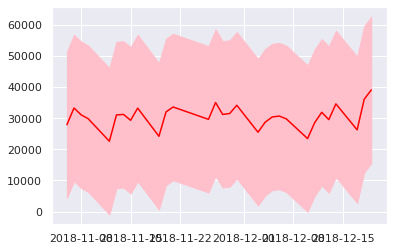

In [54]:
# make an insample prediction of last 30 days
forecast = results.get_prediction(start=-30)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
#print(confidence_intervals)
lower_limits = confidence_intervals.loc[:,'lower sale_dollars']
upper_limits = confidence_intervals.loc[:,'upper sale_dollars']

#plot values
plt.figure()
#plt.plot(y_train.index, y_train['sale_dollars'])
#plot prediction

plt.plot(mean_forecast.index,mean_forecast.values, color ='red',label='forecast')

#fill uncertainty area
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


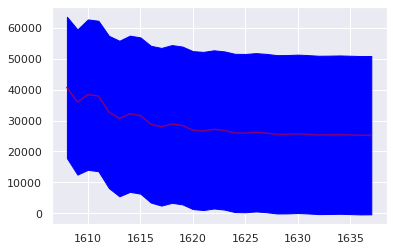

In [79]:
#Creating a 30 day forecast
forecast =results.get_forecast(steps=30)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
lower_limits = confidence_intervals.loc[:,'lower sale_dollars']
upper_limits = confidence_intervals.loc[:,'upper sale_dollars']

#plot prediction
plt.figure()
plt.plot(mean_forecast.index,mean_forecast.values, color ='purple',label='forecast')

#fill uncertainty area
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='blue')
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


8780.935879006476


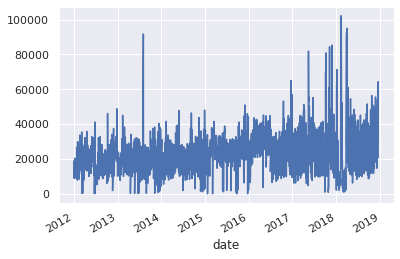

In [82]:
#verifying model performance
# Fit model
import numpy as np

model = SARIMAX(y_train['sale_dollars'], order=(p,0,q))
results = model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))

# Print mean absolute error
print(mae)

# Make plot of time series for comparison
y_train['sale_dollars'].plot()
plt.show()

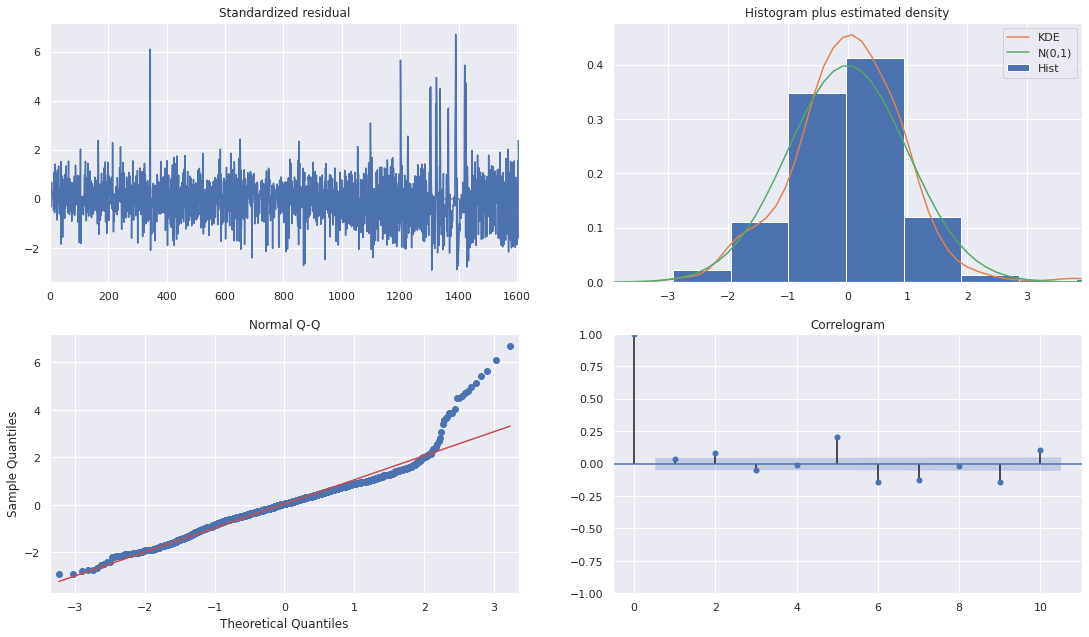

In [86]:
results.plot_diagnostics()

import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()
